In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import copy

import npeet.entropy_estimators as ee
from uncertainty_forest.uncertainty_forest import UncertaintyForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from scipy.stats import entropy, multivariate_normal
from scipy.integrate import nquad

In [4]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 
import mixed

### Generating data and prediction.

In [5]:
def split_train_eval(X, y, frac_eval):
    
    if frac_eval == 0:
        return X, y, [], []
    
    n = len(y)
    n_eval = int(np.floor(frac_eval*n))
    eval_indices = np.random.choice(np.arange(n), size = n_eval, replace = False)
    X_eval = X[eval_indices, :]
    y_eval = y[eval_indices]
    X = np.delete(X, eval_indices, axis = 0)
    y = np.delete(y, eval_indices, axis = 0)
    
    return X, y, X_eval, y_eval

def generate_data(n, d, mu = 1, var1 = 1, pi = 0.5, truncate = False, three_class = False):
    
    means, Sigma, probs = _make_params(d, mu = mu, var1 = var1, pi = pi, three_class = three_class)
    counts = np.random.multinomial(n, probs, size = 1)[0]
    
    X_data = []
    y_data = []
    for k in range(len(probs)):
        X_data.append(np.random.multivariate_normal(means[k], Sigma, counts[k]))
        y_data.append(np.repeat(2*k - 1, counts[k]))
    X = np.concatenate(tuple(X_data))
    y = np.concatenate(tuple(y_data))
    
    if truncate:
        for i in range(n):
            if X[i, 0] > 0:
                y[i] = -1
            elif X[i, 0] < 0:
                y[i] = 1
    
    return X, y

def _make_params(d, mu = 1, var1 = 1, pi = 0.5, three_class = False):
    
    if three_class:
        return _make_three_class_params(n, d, mu)
    
    mean = np.zeros(d)
    mean[0] = mu
    means = [mean, -mean]
    Sigma = np.eye(d)
    Sigma[0, 0] = var1
    probs = [pi, 1 - pi]
    
    return means, Sigma, probs

def _make_three_class_params(n, d, mu):
    
    means = []
    mean = np.zeros(d)
    mean[d-1] = mu
    means.append(copy.deepcopy(mean))
    
    mean[d-1] = 0
    mean[0] = mu
    means.append(copy.deepcopy(mean))
    
    mean[0] = -mu
    means.append(copy.deepcopy(mean))
                      
    Sigma = np.eye(d)
    probs = [1/3.]*3
    
    return means, Sigma, probs

def split_by_class(X, y):
    
    classes, class_indices = np.unique(y, return_inverse = True)
    K = len(classes)
    X_by_class = []
    y_by_class = []
    
    for k in range(K):
        class_ = classes[k]
        X_k = X[y == class_,:]
        y_k = np.repeat(class_, X_k.shape[0])
        X_by_class.append(X_k)
        y_by_class.append(y_k)
        
    return X_by_class, y_by_class

## Plot the Setting ("Look at it!")

In [6]:
def plot_setting(n, setting, ax):
    
    X, y = generate_data(n, 2, **setting['kwargs'])
        
    X_by_class, y_by_class = split_by_class(X, y)
    for k in range(len(y_by_class)):
        ax.scatter(X_by_class[k][:, 0], X_by_class[k][:, 1], color = setting['colors'][k], marker = ".")
    
    # ax.set_ylim(bottom = -5.05)
    # ax.set_ylim(top = 5.05)
    ax.set_xlim(left = -5.05)
    ax.set_xlim(right = 5.05)
    
    ax.set_ylabel(setting['name'])

In [48]:
# Setting figures.
colors = ["#d95f02", "#2166ac", "#c51b7d"]
settings = [
    {
        'name' : 'Sphereical Gaussians',
        'kwargs': {},
        'colors' : colors[1:3],
        'filename' : 'spherical'
    },
    {
        'name' : 'Elliptical Gaussians',
        'kwargs': {'var1' : 3},
        'colors' : colors[1:3],
        'filename' : 'ellyptical'
    },
    {
        'name' : 'Imbalanced Classes',
        'kwargs': {'pi' : 0.8},
        'colors' : colors[1:3],
        'filename' : 'imbalanced'
    },
#     {
#         'name' : 'Truncated Gaussians',
#         'kwargs': {'truncate' : True},
#         'colors' : colors[1:3],
#         'filename' : 'truncated'
#     },
    {
        'name' : 'Three Class Gaussians',
        'kwargs': {'mu' : 3, 'three_class' : True},
        'colors' : colors,
        'filename' : 'three_class'
    },
]

In [8]:
def estimate_mi(X, y, label, obj, frac_eval, base = 2):
    if label == 'UF':
        X, y, X_eval, y_eval = split_train_eval(X, y, frac_eval)
        obj.fit(X, y)
        return obj.estimate_mutual_info(X_eval)
    elif label == 'KSG':
        return ee.mi(X, np.array(y).reshape(-1, 1))
    elif label == 'Mixed KSG':
        return mixed.Mixed_KSG(X, y.reshape(-1, 1))
    elif label == 'IRF':
        X, y, X_eval, y_eval = split_train_eval(X, y, frac_eval)
        obj.fit(X, y)
        
        _, counts = np.unique(y, return_counts=True)
        H_Y = entropy(counts, base=base)
        
        p = obj.predict_proba(X_eval)
        H_YX = np.mean(entropy(p.T, base=base))
        return H_Y - H_YX
    else:
        raise ValueError("Uncrecognized label!")

## Effect Size Plots

In [35]:
def compute_norm_mutual_info(d, base = 2, mu = 1, var1 = 1, pi = 0.5, three_class = False, truncate = False):
    
    if truncate:
        return 1.0, 1.0, 1.0
    
    if d > 1:
        dim = 2
    else:
        dim = d
 
    means, Sigma, probs = _make_params(dim, mu = mu, var1 = var1, pi = pi, three_class = three_class)
    
    # Compute entropy and X and Y.
    def func(*args):
        x = np.array(args)
        p = 0
        for k in range(len(means)):
            p += probs[k] * multivariate_normal.pdf(x, means[k], Sigma)
        return -p * np.log(p) / np.log(base)

    scale = 10
    lims = [[-scale, scale]]*dim
    H_X, int_err = nquad(func, lims)
    H_Y = entropy(probs, base = base)
    
    # Compute MI.
    H_XY = (dim * np.log(2*np.pi) + np.log(np.linalg.det(Sigma)) + dim) / (2 * np.log(base))
    I_XY = H_X - H_XY
    norm_I_XY = I_XY / min(H_X, H_Y)
    
    return norm_I_XY, H_X, H_Y

In [10]:
def mutual_info_distribution(n, d, frac_eval, algos, num_trials, setting, mu, base = 2, parallel = False):
    
    # Compute normalizing factors.
    kwargs = copy.deepcopy(setting['kwargs'])
    kwargs['mu'] = mu
    _, H_X, H_Y = compute_norm_mutual_info(base = base, **kwargs)
    factor = min(H_X, H_Y)
    
    # For each trial, generate data and compute conditional entropy for each algorithm.
    def worker(t):
        X, y = generate_data(n, d, **kwargs)
        X, y, X_eval, _ = split_train_eval(X, y, frac_eval)
        
        ret = np.zeros(len(algos))
        for j in range(len(algos)):
            # Estimate conditional probability of Y | X.
            ret[j] = estimate_mi(X, y, algos[j]['label'], algos[j]['instance'], frac_eval) / factor
        return ret
    
    if parallel:
        predicted_mutual_info = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
    else:
        predicted_mutual_info = np.zeros((num_trials, len(algos)))
        for t in tqdm(range(num_trials)):
            predicted_mutual_info[t, :] = worker(t)
            
    return predicted_mutual_info

In [11]:
def mutual_info_by_mu(mus, n, d, frac_eval, algos, num_trials, setting, parallel = False):
    # Repeat for all 'mu', and save output in the 'algos' array.
    mutual_info_range = np.zeros((len(mus), num_trials, len(algos)))
    for i in range(len(mus)):
        mutual_info_range[i, :, :] = mutual_info_distribution(n, 
                                                              d, 
                                                              frac_eval, 
                                                              algos, 
                                                              num_trials,
                                                              setting,
                                                              mus[i], 
                                                              parallel = parallel)      
    for j in range(len(algos)):
        algos[j]['mi_by_mu_d_%d_%s' % (d, setting['filename'])] = mutual_info_range[:, :, j]
        
    with open('algos_fig3.pkl', 'wb') as f:
        pickle.dump(algos, f)
    with open('mus_fig3.pkl', 'wb') as f:
        pickle.dump(mus, f)

In [40]:
def plot_mutual_info_by_mu(mus, setting, algos, d, truth, ax):
    
    for algo in algos:
        # Plot the mean over trials as a solid line.
        ax.plot(mus, 
                np.mean(algo['mi_by_mu_d_%d_%s' % (d, setting['filename'])], axis = 1).flatten(), 
                label = algo['label'], 
                linewidth = 2, 
                color = algo['color'])
    
#     kwargs = setting['kwargs']
#     truth = np.zeros(len(mus))
#     for i in range(len(mus)):
#         kwargs['mu'] = mus[i]
#         truth[i] = compute_norm_mutual_info(d, **kwargs)[0]
    ax.plot(mus, truth, label = 'Truth', linewidth = 2, color = 'black')

    ax.set_xlabel("Effect Size")
    ax.set_ylabel("Estimated Normalized MI")
    
    ax.set_ylim(bottom = -0.05)
    ax.set_ylim(top = 1.05)
    ax.set_xlim(left = 0.05)
    ax.set_xlim(right = 5.05)

In [13]:
# Data.
n = 10000
mus = [i - 0.5 for i in range(1, 6)]
num_trials = 25
frac_eval = 0.3
n_estimators = 500
d1 = 1
d2 = 40
parallel = True

# Algorithms.
algos = [
    {
        'instance': CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = n_estimators), 
                                           method='isotonic', 
                                           cv = 5),
        'label': 'IRF',
        'title': 'Isotonic Reg. Forest',
        'color': "#fdae61",
    },
    {
        'instance': None,
        'label': 'KSG',
        'title': 'KSG',
        'color': "#1b9e77",
    },
    {
        'instance': None,
        'label': 'Mixed KSG',
        'title': 'Mixed KSG',
        'color': "purple",
    },
    {
        'instance': UncertaintyForest(n_estimators = n_estimators),
        'label': 'UF',
        'title': 'Uncertainty Forest',
        'color': "#F41711",
    },
]

In [12]:
for setting in settings:
    mutual_info_by_mu(mus, n, d1, frac_eval, algos, num_trials, setting, parallel = parallel)
    mutual_info_by_mu(mus, n, d2, frac_eval, algos, num_trials, setting, parallel = parallel)

In [38]:
# Compute true values for normalized mutual info.
def compute_truth(d, settings, mus):
    truth = np.zeros((len(settings), len(mus)))
    for s in range(len(settings)): 
        kwargs = settings[s]['kwargs']
        for i in range(len(mus)):
            kwargs['mu'] = mus[i]
            truth[s, i] = compute_norm_mutual_info(d, **kwargs)[0]
    with open('truth_fig3_d_%d.pkl' % d, 'wb') as f:
        pickle.dump(truth, f)

In [45]:
compute_truth(d1, settings, mus)
compute_truth(d2, settings, mus)

In [46]:
def plot_fig3(d1, d2):
    sns.set(font_scale = 1.5)
    sns.set_style("ticks")
    plt.rcParams["font.family"] = "sans-serif"
    fig, axes = plt.subplots(len(settings), 3, figsize = (15,20))
    
    with open('algos_fig3.pkl', 'rb') as f:
        algos = pickle.load(f)
    with open('mus_fig3.pkl', 'rb') as f:
        mus = pickle.load(f)
    
    with open('truth_fig3_d_%d.pkl' % d1, 'rb') as f:
        truth_1 = pickle.load(f)
    with open('truth_fig3_d_%d.pkl' % d2, 'rb') as f:
        truth_2 = pickle.load(f)

    for s in range(len(settings)):
        plot_setting(2000, settings[s], axes[s, 0])
        plot_mutual_info_by_mu(mus, settings[s], algos, d1, truth_1[s, :], axes[s, 1])
        plot_mutual_info_by_mu(mus, settings[s], algos, d2, truth_2[s, :], axes[s, 2])
        
    axes[0, 1].set_title('d = %d' % d1)
    axes[0, 2].set_title('d = %d' % d2)
    axes[0, 2].legend(loc = "upper right")

    plt.yticks(fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.tight_layout()
    plt.savefig("fig3.pdf")
    plt.show()

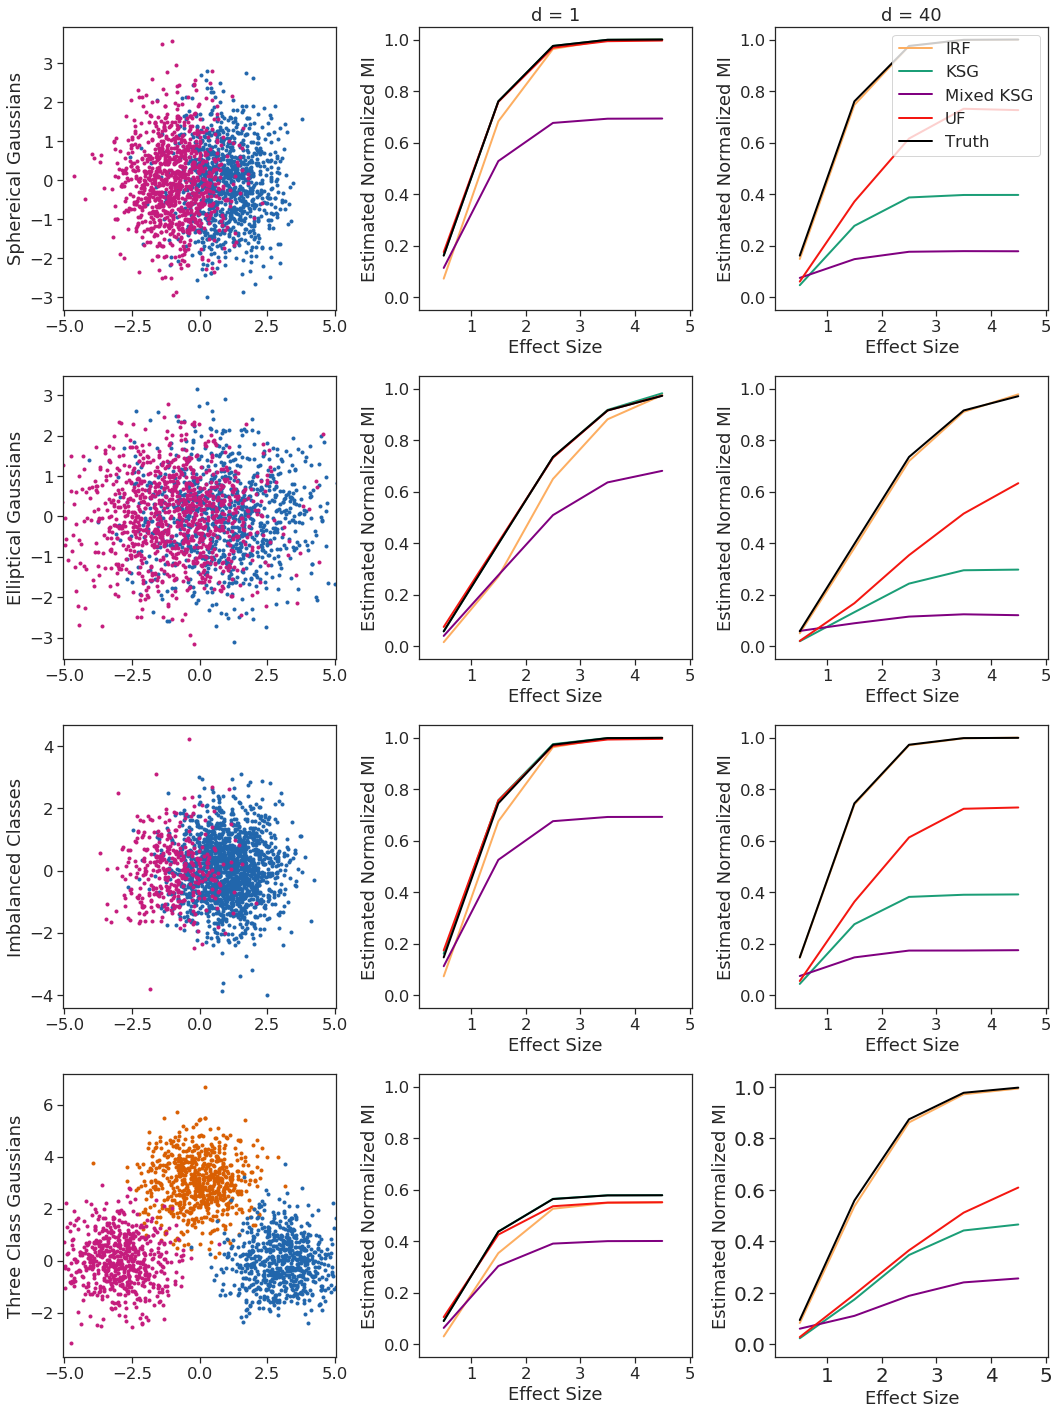

In [49]:
# Run settings cell first.
plot_fig3(d1, d2)